In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance

In [163]:
train_df = pd.read_csv("training_dataset.csv")
test_df = pd.read_csv("validation_set.csv")

In [164]:
train_df.shape

(22916, 22)

In [165]:
test_df.shape

(5729, 21)

In [166]:
train_set, val_set = train_test_split(
    train_df, test_size = 0.2,
    random_state = 43,
    stratify = train_df['berlangganan_deposito'])

In [167]:
train_set.head()

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,...,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
7840,617847,25,pemilik bisnis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,...,999,1,failure,-2.9,92.201,-31.4,0.879,5076.2,Bali,0
13592,863102,32,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,no,cellular,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,Sumatera,0
1891,542059,22,pekerja kasar,lajang,Tidak Tamat SD,unknown,yes,no,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,Sulawesi,0
7512,215221,57,teknisi,menikah,SMP,no,yes,no,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,Sumatera,0
10912,281394,29,pekerja kasar,lajang,SMP,no,yes,no,cellular,may,...,999,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1,Sulawesi,0


In [168]:
from sklearn.calibration import LabelEncoder


def apply_encoding(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.copy()
    label_encoders = {}

    for col in ret.columns:
        if ret[col].dtype == 'object' or ret[col].dtype.name == 'category':
            # Handle special cases
            if col == 'gagal_bayar_sebelumnya':
                ret[col] = ret[col].replace('unknown', np.nan)
                le = LabelEncoder()
                le.fit([x for x in ret[col].dropna().unique()] + ['unknown'])
                ret[col] = ret[col].fillna('unknown')
                ret[col] = le.transform(ret[col])
                label_encoders[col] = le

            elif col == 'hasil_kampanye_sebelumnya':
                ret[col] = ret[col].replace('nonexistent', np.nan)
                le = LabelEncoder()
                le.fit([x for x in ret[col].dropna().unique()] + ['nonexistent'])
                ret[col] = ret[col].fillna('nonexistent')
                ret[col] = le.transform(ret[col])
                label_encoders[col] = le

            elif col != 'bulan_kontak_terakhir':
                # General case: encode known, leave unknown as NaN
                known_values = ret[col][ret[col] != 'unknown']
                le = LabelEncoder()
                le.fit(known_values)
                label_encoders[col] = le

                def encode_or_nan(val):
                    return le.transform([val])[0] if val in le.classes_ else np.nan

                ret[col] = ret[col].apply(encode_or_nan)

    return ret


In [169]:
def apply_imputer(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.copy()

    # Use SimpleImputer with most_frequent strategy
    imputer = SimpleImputer(strategy='most_frequent')

    # Apply only to numeric columns (e.g., after label encoding)
    numeric_cols = ret.select_dtypes(include=['number']).columns
    ret[numeric_cols] = imputer.fit_transform(ret[numeric_cols])

    return ret


In [170]:
def apply_scaler(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.copy()

    # Initialize the scaler
    scaler = StandardScaler()

    # Select numeric columns
    numeric_cols = ret.select_dtypes(include=['number']).columns

    # Fit and transform
    ret[numeric_cols] = scaler.fit_transform(ret[numeric_cols])

    return ret


In [171]:
def apply_high_season(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.copy()
    ret['high_season'] = ret['bulan_kontak_terakhir'].apply(lambda x: 1 if x in ['oct', 'mar', 'sep', 'apr', 'dec'] else 0)
    return ret

In [172]:
# KMeans cluster for each continuous macro feature
from sklearn.cluster import KMeans
def apply_cluster(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.copy()
    
    

    ret['harga_cluster'] = KMeans(n_clusters=4, random_state=42).fit_predict(ret[['indeks_harga_konsumen']])
    ret['kepercayaan_cluster'] = KMeans(n_clusters=4, random_state=42).fit_predict(ret[['indeks_kepercayaan_konsumen']])
    ret['pekerja_cluster'] = KMeans(n_clusters=4, random_state=42).fit_predict(ret[['jumlah_pekerja']])

    return ret


In [173]:
class CustomPipeline:
    @staticmethod
    def fit_transform(X: pd.DataFrame, y: pd.Series) -> tuple:
        ret = pd.concat([X, y], axis=1)

        label_col = 'berlangganan_deposito'
        features = ret.drop(columns=[label_col])
        features = apply_encoding(features)
        features = apply_imputer(features)
        features = apply_scaler(features)
        features = apply_high_season(features)
        #features = apply_cluster(features)
        # Drop unneeded columns
        features = features.drop(columns=['customer_number', 'usia', 'status_perkawinan', 'pendidikan', 'hari_sejak_kontak_sebelumnya', 'suku_bunga_euribor_3bln', 
                                          'bulan_kontak_terakhir', "pekerjaan", 'pulau', 'pinjaman_rumah', 'pinjaman_pribadi'])

        return (features, y)

    @staticmethod
    def transform(df: pd.DataFrame) -> pd.DataFrame:
        ret = df.copy() 

        ret = apply_encoding(ret)
        ret = apply_imputer(ret)
        ret = apply_scaler(ret)
        ret = apply_high_season(ret)
        #ret = apply_cluster(ret)

        ret = ret.drop(columns=['customer_number', 'usia', 'status_perkawinan', 'pendidikan', 'hari_sejak_kontak_sebelumnya','suku_bunga_euribor_3bln',
                                'bulan_kontak_terakhir', 'pekerjaan', 'pulau', 'pinjaman_rumah', 'pinjaman_pribadi'])

        return ret


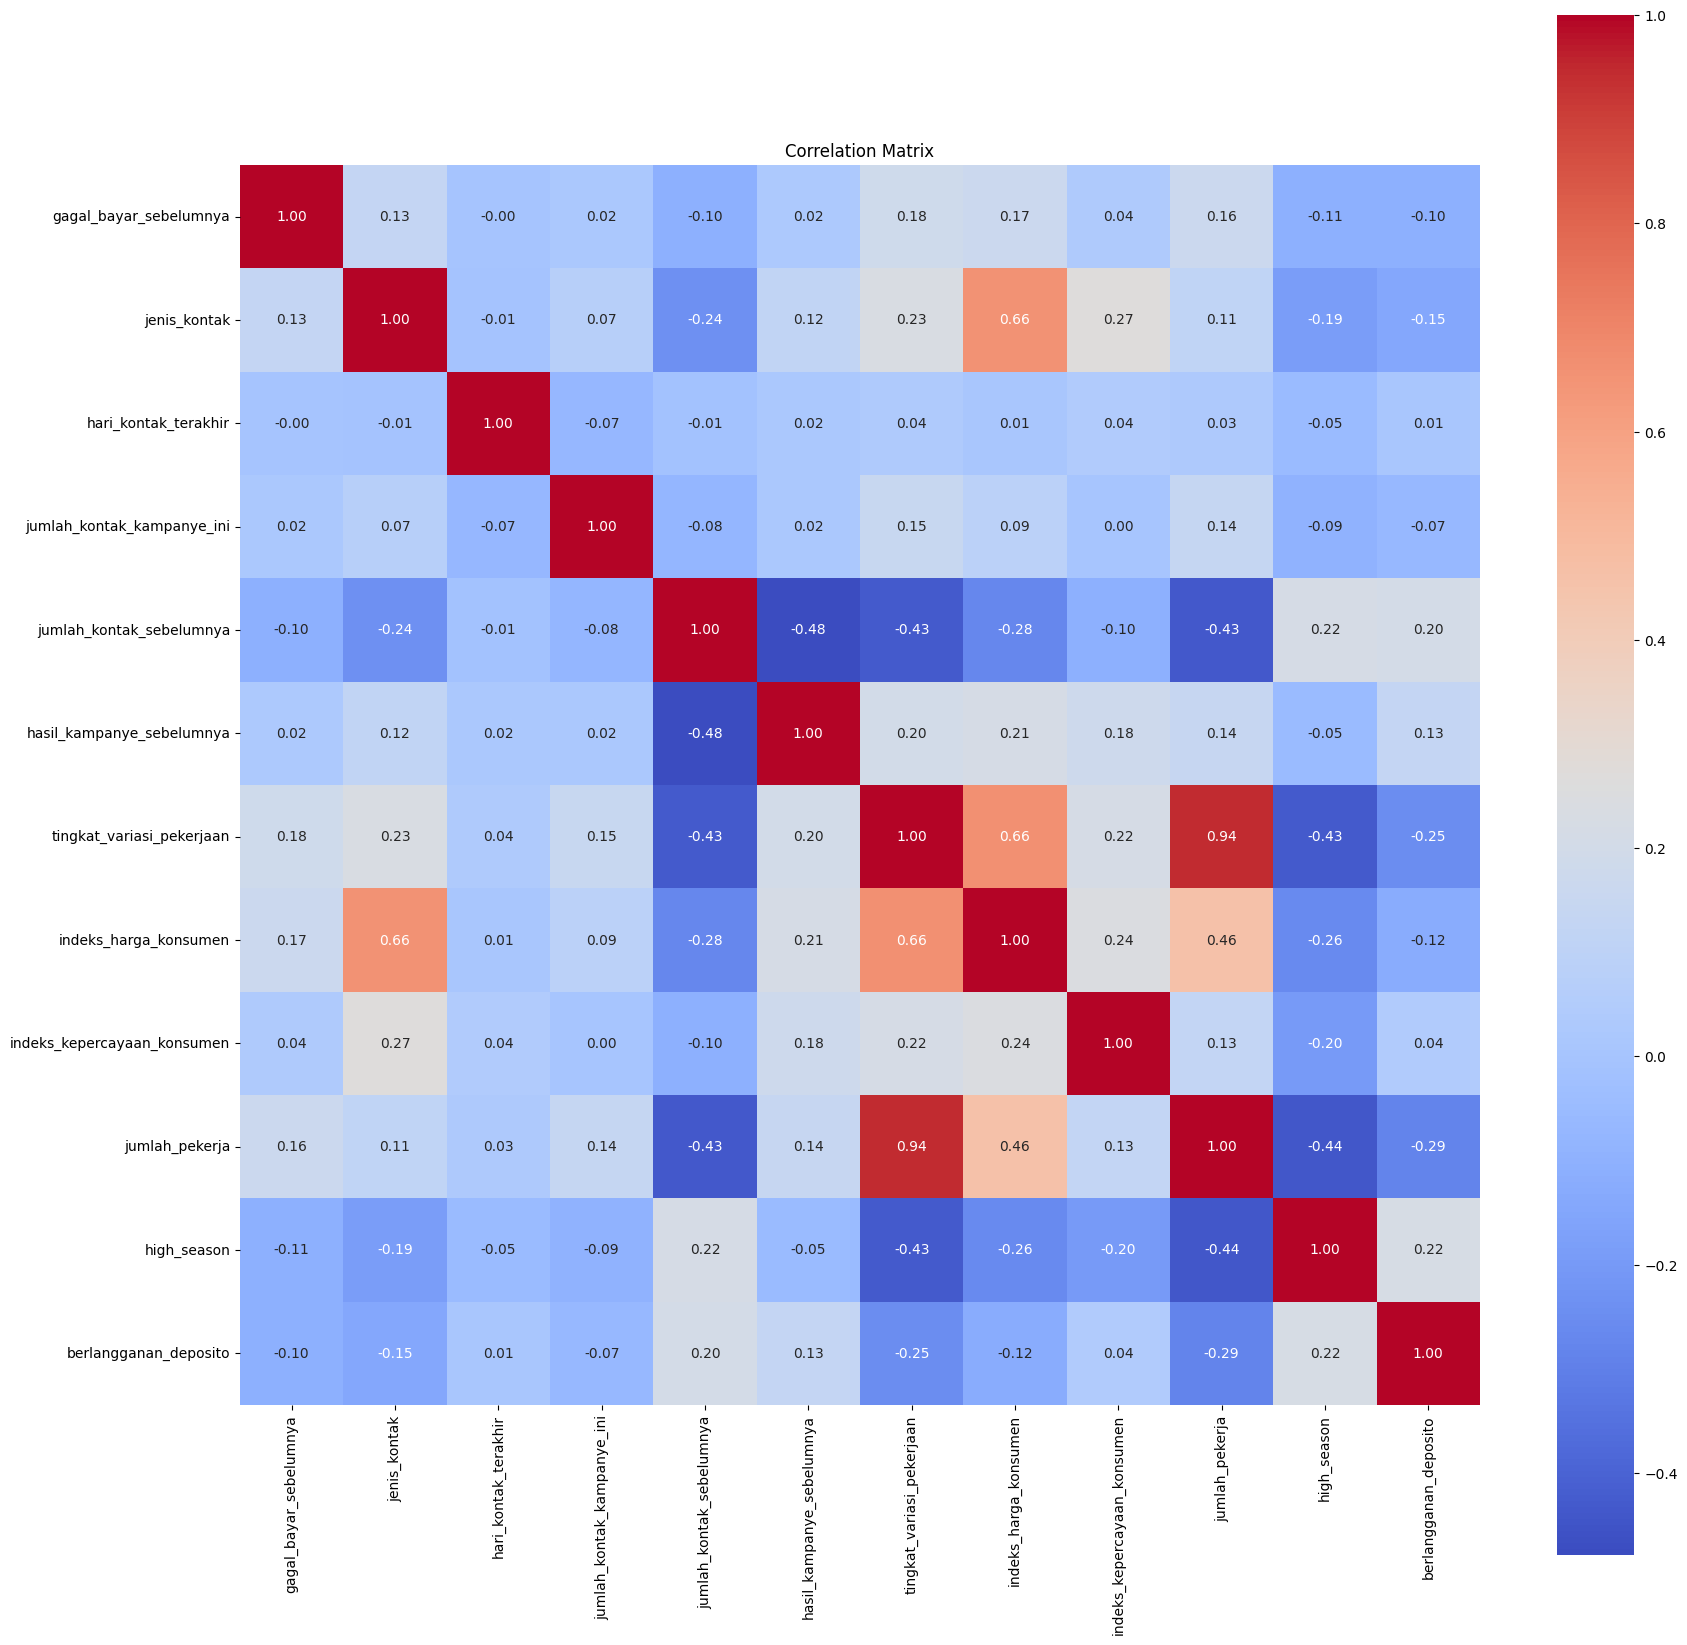

In [174]:
coba, cobaa = CustomPipeline.fit_transform(train_set.drop(columns=['berlangganan_deposito']), train_set['berlangganan_deposito'])
coba['berlangganan_deposito'] = cobaa
corr_matrix = coba.corr(method='spearman')
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [175]:
coba.head()

,gagal_bayar_sebelumnya,jenis_kontak,hari_kontak_terakhir,jumlah_kontak_kampanye_ini,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,jumlah_pekerja,high_season,berlangganan_deposito
7840,-0.511363,-0.757963,1.424621,-0.203871,1.719885,-2.595823,-1.900132,-2.379085,1.971986,-1.254934,0,0
13592,-0.511363,-0.757963,0.709952,0.518394,-0.348128,0.183607,0.837568,-0.232402,0.955651,0.842669,0,0
1891,1.952966,-0.757963,-1.434055,-0.565004,-0.348128,0.183607,0.837568,0.586205,-0.471542,0.842669,0,0
7512,-0.511363,1.319325,0.709952,-0.565004,-0.348128,0.183607,0.646565,0.717458,0.890779,0.330352,0,0
10912,-0.511363,-0.757963,1.424621,-0.565004,-0.348128,0.183607,-1.199790,-1.183988,-1.228387,-0.938705,0,0


Validation ROC AUC: 0.7975
Validation F1 Score: 0.3394
Validation Precision: 0.6368
Validation Recall: 0.2314


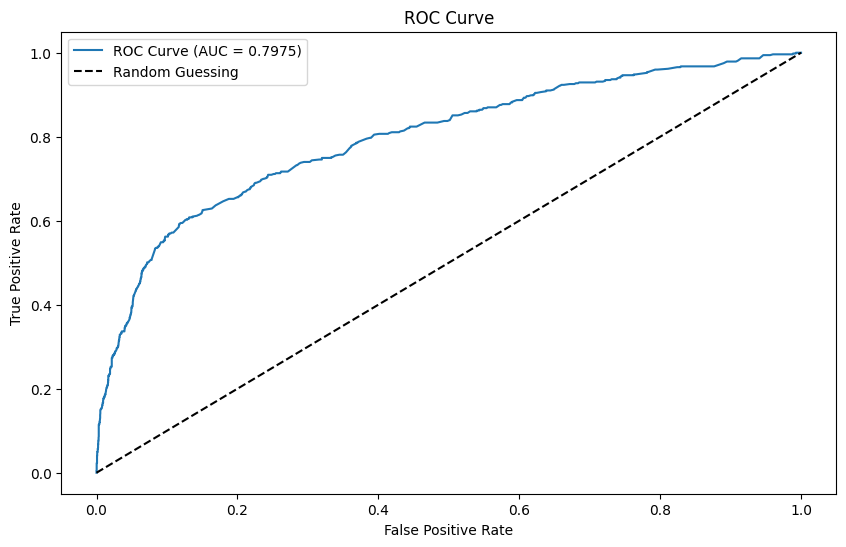

In [176]:
X_train = train_set.drop(columns=["berlangganan_deposito"])
y_train = train_set["berlangganan_deposito"]

(X_train, y_train) = CustomPipeline.fit_transform(X_train, y_train)
X_val = val_set.drop(columns=["berlangganan_deposito"])
y_val = val_set["berlangganan_deposito"]

X_val = CustomPipeline.transform(X_val)
model = GradientBoostingClassifier( n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    min_samples_leaf=5,
    max_features='sqrt',
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42)
model.fit(X_train, y_train)
y_val_pred = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC AUC: {roc_auc:.4f}")
# f1 score, precision, recall, confusion matrix
print(f"Validation F1 Score: {f1_score(y_val, (y_val_pred > 0.5).astype(int)):.4f}")
print(f"Validation Precision: {precision_score(y_val, (y_val_pred > 0.5).astype(int)):.4f}")
print(f"Validation Recall: {recall_score(y_val, (y_val_pred > 0.5).astype(int)):.4f}")
#pr auc
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [177]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import numpy as np

# Prepare the full dataset (drop target from features)
X = train_set.drop(columns=["berlangganan_deposito"])
y = train_set["berlangganan_deposito"]

# Define K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for metrics
roc_aucs, f1s, precisions, recalls = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # Apply your pipeline
    X_train, y_train = CustomPipeline.fit_transform(X_train, y_train)
    X_val = CustomPipeline.transform(X_val)

    # Train model
    model = GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_leaf=5,
        max_features='sqrt',
        validation_fraction=0.1,
        n_iter_no_change=10,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Evaluate
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)

    roc_aucs.append(roc_auc_score(y_val, y_val_pred_proba))
    f1s.append(f1_score(y_val, y_val_pred))
    precisions.append(precision_score(y_val, y_val_pred))
    recalls.append(recall_score(y_val, y_val_pred))

    print(f"Fold {fold} - ROC AUC: {roc_aucs[-1]:.4f}, F1: {f1s[-1]:.4f}, Precision: {precisions[-1]:.4f}, Recall: {recalls[-1]:.4f}")

# Average results
print("\n--- Average Metrics ---")
print(f"ROC AUC: {np.mean(roc_aucs):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")


Fold 1 - ROC AUC: 0.7857, F1: 0.3387, Precision: 0.6643, Recall: 0.2273
Fold 2 - ROC AUC: 0.7931, F1: 0.3265, Precision: 0.5828, Recall: 0.2267
Fold 3 - ROC AUC: 0.8071, F1: 0.3816, Precision: 0.7297, Recall: 0.2584
Fold 4 - ROC AUC: 0.7903, F1: 0.2578, Precision: 0.7021, Recall: 0.1579
Fold 5 - ROC AUC: 0.7925, F1: 0.3680, Precision: 0.6391, Recall: 0.2584

--- Average Metrics ---
ROC AUC: 0.7937
F1 Score: 0.3345
Precision: 0.6636
Recall: 0.2257


In [178]:
# from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
# from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# # Prepare the data
# X_train = train_set.drop(columns=["berlangganan_deposito"])
# y_train = train_set["berlangganan_deposito"]
# (X_train, y_train) = CustomPipeline.fit_transform(X_train, y_train)

# X_val = val_set.drop(columns=["berlangganan_deposito"])
# y_val = val_set["berlangganan_deposito"]
# X_val = CustomPipeline.transform(X_val)

# # If needed, encode y to 0/1 (e.g., 'yes'/'no')
# if y_train.dtype == 'object':
#     y_train = y_train.map({'no': 0, 'yes': 1})
#     y_val = y_val.map({'no': 0, 'yes': 1})

# # Define models
# models = {
#     "Logistic Regression": LogisticRegression(max_iter=1000),
#     "Decision Tree": DecisionTreeClassifier(),
#     "Random Forest": RandomForestClassifier(),
#     "Gradient Boosting": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, subsample=0.8, min_samples_leaf=5, max_features='sqrt', validation_fraction=0.1, n_iter_no_change=10, random_state=42),
#     "AdaBoost": AdaBoostClassifier(),
#     "K-Nearest Neighbors": KNeighborsClassifier(),
#     "Naive Bayes": GaussianNB(),
#     "Support Vector Machine": SVC(probability=True),
#     "Extra Trees": ExtraTreesClassifier(),
#     "Bagging Classifier": BaggingClassifier()
# }

# # Evaluate all models
# results = []

# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred_prob = model.predict_proba(X_val)[:, 1]
#     y_pred = (y_pred_prob > 0.5).astype(int)

#     roc_auc = roc_auc_score(y_val, y_pred_prob)
#     f1 = f1_score(y_val, y_pred)
#     precision = precision_score(y_val, y_pred)
#     recall = recall_score(y_val, y_pred)

#     results.append({
#         "Model": name,
#         "ROC AUC": roc_auc,
#         "F1 Score": f1,
#         "Precision": precision,
#         "Recall": recall
#     })

# # Display results
# results_df = pd.DataFrame(results).sort_values(by="ROC AUC", ascending=False)
# print(results_df)


In [179]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import cross_val_score

# # Base learners
# base_learners = [
#     ('gb', GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, subsample=0.8, random_state=42)),
#     ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
#     ('nb', GaussianNB()),
#     ('lr', LogisticRegression(max_iter=1000))
# ]

# # Meta learner
# meta_learner = LogisticRegression(max_iter=1000)

# # Stacking model
# stack_model = StackingClassifier(
#     estimators=base_learners,
#     final_estimator=meta_learner,
#     cv=5,
#     passthrough=True
# )

# # Train and evaluate
# stack_model.fit(X_train, y_train)
# y_pred = stack_model.predict_proba(X_val)[:, 1]

# # Metrics
# print(f"Stacking ROC AUC: {roc_auc_score(y_val, y_pred):.4f}")
# print(f"Stacking F1 Score: {f1_score(y_val, (y_pred > 0.5).astype(int)):.4f}")
# print(f"Stacking Precision: {precision_score(y_val, (y_pred > 0.5).astype(int)):.4f}")
# print(f"Stacking Recall: {recall_score(y_val, (y_pred > 0.5).astype(int)):.4f}")


 99%|===================| 18115/18332 [01:17<00:00]        

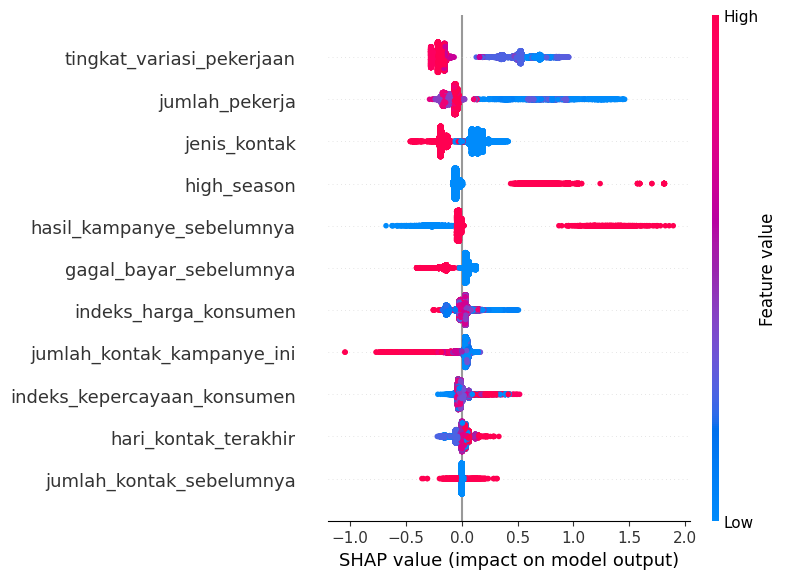

In [180]:
import shap

X_train = train_set.drop(columns=["berlangganan_deposito"])
y_train = train_set["berlangganan_deposito"]
X_test = val_set.drop(columns=["berlangganan_deposito"])
y_test = val_set["berlangganan_deposito"]
# X_train, y_train = CustomPipeline.fit_transform(X_train, y_train)
(X_train, y_train) = CustomPipeline.fit_transform(X_train, y_train)
X_test = CustomPipeline.transform(X_test)

model.fit(X_train, y_train)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train, check_additivity=False)

shap.summary_plot(shap_values, X_train)
shap.plots.force(shap_values[0])
